In [73]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from isna_test import isna_test

### Загрузка и обработка данных

In [74]:
# загрузка данных
df = pd.read_csv('./data/ds_salaries.csv')
df_copy = df.copy(deep=True)

In [75]:
df.head(5)

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [76]:
# типы столбцов и кол-во значений в каждом
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


In [77]:
# проверяем кол-во уникальных значений в столбцах
df.nunique()

Unnamed: 0            607
work_year               3
experience_level        4
employment_type         4
job_title              50
salary                272
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

In [78]:
# ищем и удаляем пропуски
isna_test(df)

пропусков нет


In [79]:
# ищем и удаляем дубликаты
if df.duplicated().sum() > 0:
    print('в данных есть построковые дубликаты')
    df = df.drop_duplicates()
else:
    print('дубликатов нет')

дубликатов нет


<Axes: >

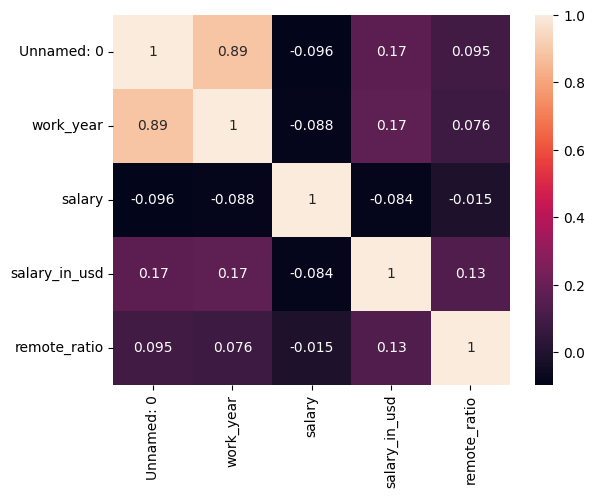

In [80]:
# строим матрицу корреляций
sns.heatmap(df.corr(numeric_only=True), annot=True)

Взаимной корреляции между числовыми призгаками нет. Признак Unnamed (номер строки) не несет полезной инофрмации, его можно удалить. Также можно удалить столбец salary, так как он в разных единицах. Столбец salary_in_usd информативнее. Столбцы year и remote_ratio можно определить как категориальные исходя из количества уникальных значений в них.

In [81]:
df = df.drop(columns=['Unnamed: 0', 'salary'], axis=1)

In [82]:
# проверим на кол-во уникальных значений
df.nunique()

work_year               3
experience_level        4
employment_type         4
job_title              50
salary_currency        17
salary_in_usd         369
employee_residence     57
remote_ratio            3
company_location       50
company_size            3
dtype: int64

In [83]:
# применяем для всех нечисловых признаков тип category для оптимизации
df['work_year'] = df['work_year'].astype('category')
df['remote_ratio'] = df['remote_ratio'].astype('category')
df[df.select_dtypes(include=['object']).columns] = df[df.select_dtypes(
    include=['object']).columns].astype('category')

In [84]:
# основные статистики для количественных признаков
df.describe()

,salary_in_usd
count,607.000000
mean,112297.869852
std,70957.259411
min,2859.000000
25%,62726.000000
50%,101570.000000
75%,150000.000000
max,600000.000000


### 2.1. Визуальный анализ данных

В итоге реальных количесвенных признаков совсем немного. Зарплата скорее всего будет таргетом. Поэтому единсвенный признак - доля времени работы на УД.

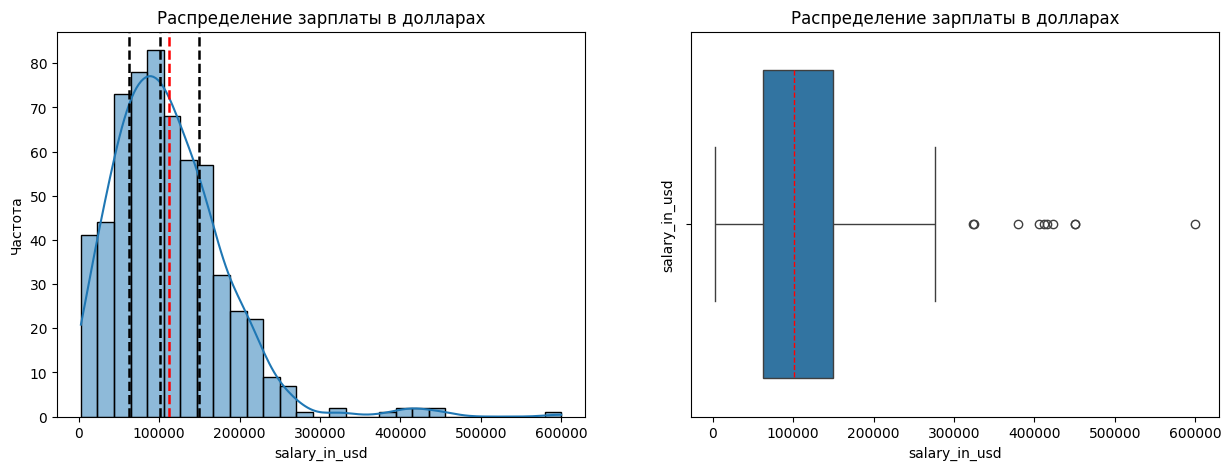

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(df['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='salary_in_usd', ylabel='Частота')
axes[0].set_title('Распределение зарплаты в долларах')
axes[0].axvline(df['salary_in_usd'].mean(), color='red',
                linestyle='--', linewidth=1.8)
axes[0].axvline(df['salary_in_usd'].median(), color='black',
                linestyle='--', linewidth=1.8)
axes[0].axvline(df['salary_in_usd'].quantile(0.25), color='black',
                linestyle='--', linewidth=1.8)
axes[0].axvline(df['salary_in_usd'].quantile(0.75), color='black',
                linestyle='--', linewidth=1.8)
sns.boxplot(df['salary_in_usd'], ax=axes[1], orient='h',
            medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='salary_in_usd')
axes[1].set_title('Распределение зарплаты в долларах')

plt.show()

In [86]:
# основные статистики непрерывных параметров
df['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

Традиционно распределение зарплат не нормальное. При этом хвост с высокими значениями не большой и среднее от медианы отличается незначительно (112 и 101 тыс. долл.). Максимальные знаения вполне реальные и считать их выбросами не стоит. Стд размером 71 тыс. долл. говорит об очень высоком разбросе зарплат. 

In [87]:
fig = px.histogram(df,
                   x='work_year',
                   title='Распределение данных о ЗП по годам',
                   labels={'work_year': 'Год', 'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

In [88]:
# рассчет доля каждой категории в выборке
df['work_year'].value_counts(normalize=True)

work_year
2022    0.523888
2021    0.357496
2020    0.118616
Name: proportion, dtype: float64

С каждым годом данных о ЗП дата сайнтистов больше. Возможно, в данный период профессия DS резко набирала популярность.

In [89]:
fig = px.bar(df.groupby(by='work_year', sort=True, observed=True)['salary_in_usd'].median().reset_index(),
             x='work_year',
             y='salary_in_usd',
             title='Медианная зарплата по годам',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'work_year': 'Год'},
             text_auto=True,
             )

fig.update_xaxes(type='category')
fig.show()

На графике выше видно, что в 2020 и 2021 года медианная ЗП почти не отличается. Но в 2022 году наблюдается значительный рост. Возможно это связано с популяризацией машинного обучения и послековидном росте сферы услуг.
Визуальный анализ показывает, что признак work_year влияет на уровень ЗП.

In [90]:
fig = px.histogram(df,
                   x='experience_level',
                   title='Распределение по уровню компетенций',
                   labels={'experience_level': 'Уровень компетенций',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Наибольшее количество специалистов в выборке имеют компетенции уровня  Senior-level/Expert и Mid-level/Intermediate, специалистов Entry-level/Junior значительно меньше, и  Executive-level/Director меньше всех.

In [91]:
fig = px.bar(df.groupby(by='experience_level', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='experience_level',
             y='salary_in_usd',
             title='Медианная зарплата по уровню компетенций',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'experience_level': 'Уровень компетенций'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Ожидаемо чем выше уровень компетенций, тем выше зарплата. Один из важнейших признаков.

In [92]:
fig = px.histogram(df,
                   x='employment_type',
                   title='Распределение по типу трудоустройства',
                   labels={'employment_type': 'Тип трудоустройства',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Ожидаемо полный рабочий день является преобладающим типом трудоустройства. Остальные варианты имеют незначительную долю, что сильно искажает выборку с точки зрения определения статистик по каждому типу.

In [93]:
fig = px.bar(df.groupby(by='employment_type', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='employment_type',
             y='salary_in_usd',
             title='Медианная зарплата по типу трудоустройства',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'employment_type': 'Тип трудоустройства'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Наибольшие ЗП у тех, кто работает по контракту или в офисе. Но результаты данного вывода ненадежны, так как группы несбалансированные, что может искажать статистику.

In [94]:
# так как в колонке job_title много категорий, то нужно выбрать наиболее популярные для визуализации
counts = df['job_title'].value_counts(normalize=True)
others = counts[counts < 0.01].index
df['job_title_group'] = df['job_title'].apply(
    lambda x: "other" if x in others else x)

In [95]:
fig = px.histogram(df,
                   x='job_title_group',
                   title='Распределение по направлению DS',
                   labels={'job_title_group': 'Направление DS',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Самые популярные роли Data Scientist, Data Engineer, Data Analyst, Machine Learning Engineer. Также стоит отметить, что остальные специальности занимают очень небольшую долю в выборке (менее 1%) и их очень много.

In [96]:
fig = px.bar(df.groupby(by='job_title_group', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='job_title_group',
             y='salary_in_usd',
             title='Медианная зарплата по направлениям DS',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'job_title_group': 'Направление DS'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Группировка по специальности (направлению) показала, что в зависимости от направления ЗП сильно отличается. Не исключено, что из-за низкой представительности большинства классов данная статистика не лучшим образом отражает реальную картину. Но если допустить, что мы доверяем полученным результатам, то признак обязательно нужно учесть. 

In [97]:
# так как в employee_residence много категорий, то нужно выбрать наиболее популярные для визуализации
counts = df['employee_residence'].value_counts(normalize=True)
others = counts[counts < 0.01].index
df['employee_residence_group'] = df['employee_residence'].apply(
    lambda x: "other" if x in others else x)

In [98]:
fig = px.histogram(df,
                   x='employee_residence_group',
                   title='Распределение по стране проживания',
                   labels={'employee_residence_group': 'Страна проживания',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Самая популярная страна проживания - США. Также относительно большой вклад вносят некоторые страны европы, Канада и Индия. В целом выборка несбалансированая, что в контексте распределения по странам ожидаемо.

In [99]:
fig = px.bar(df.groupby(by='employee_residence_group', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='employee_residence_group',
             y='salary_in_usd',
             title='Медианная зарплата по типу трудоустройства',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'employee_residence_group': 'Страна проживания'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Анализируя график выше, можно сделать вывод, что США резко вырываются по уровню ЗП для DS. А индия резко отстает, что ожидаемо.

In [100]:
fig = px.histogram(df,
                   x='remote_ratio',
                   title='Распределение по формату работы',
                   labels={'remote_ratio': 'Доля времени работы удаленно',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Весьма неожиданный результат анализа - подавляющее большинство специалистов работают преимущественно удаленно. Гибридный и офисный формат имеют сопоставимы по вкладу.


In [101]:
fig = px.bar(df.groupby(by='remote_ratio', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='remote_ratio',
             y='salary_in_usd',
             title='Медианная зарплата по форматам работы',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'remote_ratio': 'Формат работы (доля времени работы вне офиса)'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Специалисты, работающие вне офиса, зарабатывают больше остальных. У специалистов, работающих в гибридном формате наименьшие зарплаты.   Возможно, это связано с тем, что на удаленную работу чаще всего берут наиболее ценных специалистов с большим опытом.

In [102]:
fig = px.histogram(df,
                   x='company_size',
                   title='Распределение по размеру компании',
                   labels={'company_size': 'Размер компании',
                           'count': 'Количество'},
                   text_auto=True
                   )

fig.update_xaxes(type='category')
fig.show()

Большая часть опрошенных специалистов работают в средних по размеру компаниях. В маленьких компаниях работает меньше всего. Было бы интересно узнать сколько опрошенных работает в биг-техах.

In [103]:
fig = px.bar(df.groupby(by='company_size', observed=True)['salary_in_usd'].median().reset_index().sort_values(by='salary_in_usd'),
             x='company_size',
             y='salary_in_usd',
             title='Медианная зарплата в разных по размеру компаниях',
             labels={'salary_in_usd': 'Зарплата в USD',
                     'company_size': 'Размеры компании'},
             text_auto=True
             )

fig.update_xaxes(type='category')
fig.show()

Выгоднее всего работать в средних по размеру компаниях. В маленьких компаниях уровень дохода ссотрудников в два раза меньше. В крупных копмпаних доход близок к средним компаниям. Параметр размера компании явно влияет на зарплату.

Основываясь на первичном визуальном анализе данных можно сказать, что все проанализированные факторы в той или иной степени влияют на уровень дохода. Но из-за значительной неспалансировасти категорий по некоторым параметрам качество таких выводов невысокое.

### 2.2. Статистический анализ данных

Проводить статистические тесты целесообразно только для групп с представительной выборкой и в тех случаях, когда визуальный анализ не дал уверенного ответа. Либо в случаях, когда необходимо подкрепить результаты выводов математическими расчетами ввиду особой важности.

Исходя из этого предлагается с помощью тестов проверить следующие гипотезы:
- каждый год ЗП растет (из ТЗ);
- ЗП Data Scientist ниже чем у Data Engineer и выше Data Analysys (из ТЗ);
- ЗП Data Scientist выше в средних по размеру компаниях (из ТЗ);
- в крупыных компаниях больше должностей Data Scientist и Data Engineer (из ТЗ);
- ЗП зависит от доли времени работы на УД (желательно точечно проверить две близкие по медиане группы);
- ЗП зависит от размера компании;
- в США больше средних по размеру компаний, чем в остальном мире;
- Удаленно чаще работают специалисты с опытом.

### Проверка на нормальность количественного признака - зарплата в USD

Статистический тест Шапиро-Уилка на нормальность распределения.

H0 - распределение нормальное. 

H1 - ненормальное.

Уровень значимости alpha примем 0.05 (вероятность ошибки первого рода).

In [104]:
# проверка на нормальность количественного признака используя статистический тест
alpha = 0.05
stat, p = stats.shapiro(df['salary_in_usd'])
print('p-value = %.3f' % (p))
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')

p-value = 0.000
Распределение не нормальное


p_value < 0.05, следовательно опровергаем H0 и принимаем H1 (распределение ненормальное)

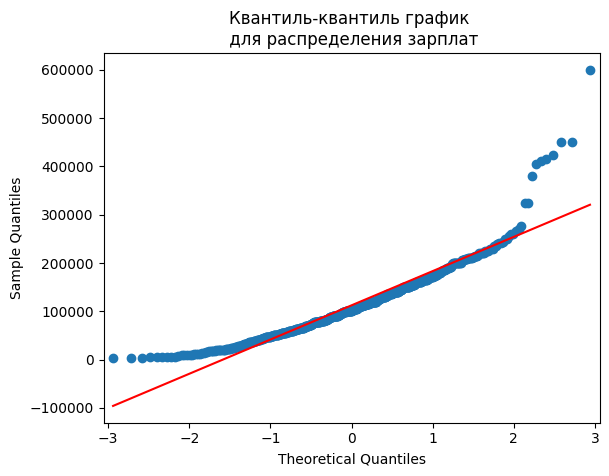

In [105]:
# проверка на нормальность количественного признака на квантиль-квантиль графике

sm.qqplot(df['salary_in_usd'], line='s')
plt.title('Квантиль-квантиль график \n для распределения зарплат')
plt.show()

И статистический тест и визуальный анализ показывают, что распределение зарплат не подчиняется нормальному распределению.

### Проверка гипотез.

### 1. Каждый год ЗП специалистов DS увеличивается.

Проверим это с помощью статистического теста.
У нас 3 > 2 группы. Распределение ЗП не подчиняется нормальному закону.
Группы независимы (каждый год количество специалистов разное). Если бы мы проверяли одних и тех же кандидатов в динамике, то использовали тест Фридмана (основан на рангах и требует одинаковой длины признаков).
В нашем случае подходит ***тест Краскела Уоллиса***.

H0 - между выборками нет различий.

H1 - между выборками есть различия.

In [106]:
# выведем основные статистические показатели по ЗП с группировкой по году
df.groupby(by='work_year', observed=True)['salary_in_usd'].agg(
    ['mean', 'median', 'std']).reset_index()

,work_year,mean,median,std
0,2020,95813.000000,75544.0,82831.799222
1,2021,99853.792627,82528.0,80225.106319
2,2022,124522.006289,120000.0,58183.647585


In [107]:
alpha = 0.05
stat, p = stats.kruskal(df['salary_in_usd'][df['work_year'] == 2020],
                        df['salary_in_usd'][df['work_year'] == 2021],
                        df['salary_in_usd'][df['work_year'] == 2022])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.000, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Тест Краскела Уоллиса показал, что существует статистически значимые различия медиан между тремя выборками (три года). Ранее при визуализации мы видели, что каждый год зарплата растет. Следовательно различия в медианах можно интерпретировать следующим образом - ***каждый год зарплата DS специалистов растет***.

### 2. ЗП у Data Scientist ниже чем у Data Engineer и выше Data Analyst

In [108]:
# выведем основные статистические показатели по ЗП с группировкой по направлению
df.groupby(by='job_title', observed=True)['salary_in_usd'].agg(
    ['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)

,job_title,count,mean,median,std
22,Data Scientist,143,108187.832168,103691.0,64112.840519
17,Data Engineer,132,112725.000000,105500.0,57629.082107
12,Data Analyst,97,92893.061856,90320.0,39961.075848
38,Machine Learning Engineer,41,104880.146341,87932.0,63218.626439
48,Research Scientist,16,109019.500000,76263.5,98542.763968
21,Data Science Manager,12,158328.500000,155750.0,52589.180497
16,Data Architect,11,177873.909091,180000.0,45714.721424
7,Big Data Engineer,8,51974.000000,41305.5,42954.761263
41,Machine Learning Scientist,8,158412.500000,156500.0,79514.714496
15,Data Analytics Manager,7,127134.285714,120000.0,17853.383299


Проверим гипотезу в три этапа для упрощения интерпретации тестов.
Будем сравнивать две независимые группы с ненормальным распределением признака.
Для данной задачи подходит U-критерий Манна.

H0 -  Распределения двух независимых выборок не отличаются.

H1 - Cуществует статистически значимое отличие между группами.

In [109]:
# сравнение ЗП Data Scientist и Data Engineer
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['job_title'] == 'Data Scientist'],
                             df['salary_in_usd'][df['job_title'] == 'Data Engineer'])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.467, что больше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза не отвергается


In [110]:
# сравнение ЗП Data Scientist и Data Analyst
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['job_title'] == 'Data Scientist'],
                             df['salary_in_usd'][df['job_title'] == 'Data Analyst'])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.101, что больше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза не отвергается


In [111]:
# сравнение ЗП Data Engineer и Data Analyst
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['job_title'] == 'Data Engineer'],
                             df['salary_in_usd'][df['job_title'] == 'Data Analyst'])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.020, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Вывод: нет основания утверждать, что уровень дохода Дата сайнтистов отличается от Дата инженеров или Дата аналитиков.
Но при сравнении ЗП Дата инженеров и Дата аналитиков нулевая гипотеза была отвергнута, следовательно Дата инженеры получат больше, чем Дата аналитики.

Также результат можно интерпретировать следующим образом: ***в целом ЗП Дата инженеров и Дата Сайнтистов схожи, а ЗП дата аналитиков ниже***.

### 3. ЗП Data Scientist выше в средних по размеру компаниях (из ТЗ);

In [112]:
# выведем основные статистические показатели по ЗП с группировкой по размеру компании
df[df['job_title'] == 'Data Scientist'].groupby(by='company_size', observed=True)['salary_in_usd'].agg(
    ['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)

,company_size,count,mean,median,std
1,M,77,126380.753247,130000.0,56389.528710
0,L,45,103313.355556,90734.0,71815.176484
2,S,21,51925.761905,49268.0,33216.289638


Имеет смысл сравнивать ЗП в средних и больших по размеру компаниях. ЗП в маленьеих команиях значительно ниже, что очевидно без статистических тестов.
Будем сравнивать две независимые группы с ненормальным распределением признака.
Для данной задачи подходит U-критерий Манна.

H0 -  Распределения двух независимых выборок не отличаются.

H1 - Cуществует статистически значимое отличие между группами.

In [113]:
# сравнение ЗП в больших и средних по размеру компаниях
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['company_size'] == 'L'],
                             df['salary_in_usd'][df['company_size'] == 'M'])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.216, что больше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза не отвергается


Результат расчета показал, что нет статистически значимой разницы в распределении ЗП Дата сайнтистов в больших и средних по размеру компаниях.

### 4. в крупыных компаниях больше должностей Data Scientist и Data Engineer (из ТЗ);


In [114]:
# подготовка бинарных признаков (1 - Data Scientis и Data Engineer, 0 - остальные специальности)
df['job_title_binar'] = df['job_title'].apply(
    lambda x: 1 if x == 'Data Scientis' or x == 'Data Engineer' else 0)
df['job_title_binar'] = df['job_title_binar'].astype('category')

# создаем таблицу сопряженности
table = pd.crosstab(df['job_title_binar'], df['company_size'])
table

company_size,L,M,S
job_title_binar,,,
0,161,237,77
1,37,89,6


Учитывая размер таблица и необходимость проверки связи двух категориальных переменных (наличие должности и размер компании), будем использовать критерий хи2.

H0: нет различий между наблюдаемыми и ожидаемыми частотами, то есть  переменные независимы.

H1: есть статистически значимые различия между наблюдаемыми и ожидаемыми частотами, переменные связаны.

In [115]:
alpha = 0.05
stat, p, stat, stat = stats.chi2_contingency(table)
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.000, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Расчёт показал, что нулевая гипотеза отвергается. Значит ***есть статистически значимая связь между размером компании и наличием должности Дата Сайнтиста и Дата Инженера***. 
Попробуем дать более точный ответ рассчитав долю должностей Дата Сайнтистов и Дата Инженеров по каждой группе.

In [116]:
table_ = table.transpose()
proportion = table_[1] / (table_[0] + table_[1])
proportion

company_size
L    0.186869
M    0.273006
S    0.072289
dtype: float64

Как видно в маленьких компаниях требуется меньше Дата Сайнтистов и Дата инженеров, а в средних по размеру значительно больше. В это есть логика - маленькие компании просто не могут позволить себе большой штат Дата Сайнтистов.

### 5. ЗП зависит от доли времени работы на УД;


In [117]:
# выведем основные статистические показатели по ЗП с группировкой по размеру компании
df[df['job_title'] == 'Data Scientist'].groupby(by='remote_ratio', observed=True)['salary_in_usd'].agg(
    ['count', 'mean', 'median', 'std']).reset_index().sort_values(by='count', ascending=False)

,remote_ratio,count,mean,median,std
2,100,79,123125.936709,123000.0,69370.994779
0,0,39,99520.743590,95550.0,58259.423987
1,50,25,74504.080000,62726.0,35602.824979


Имеет смысл сравнивать ЗП в зависимости от формата работы в два этапа. Сначала сравнить ЗП удаленщиков и офисных, затем офисных и гибридников. Так получится дать более точную интерпретацию.

Будем сравнивать две независимые группы с ненормальным распределением признака.
Для данной задачи подходит U-критерий Манна.

H0 - Распределения двух независимых выборок не отличаются.

H1 - Существует статистически значимое отличие между группами.

In [118]:
# сравнение ЗП удаленщиков и офисных
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['remote_ratio'] == 100],
                             df['salary_in_usd'][df['remote_ratio'] == 0])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.014, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


In [119]:
# сравнение ЗП  офисных и гибридников
alpha = 0.05
stat, p = stats.mannwhitneyu(df['salary_in_usd'][df['remote_ratio'] == 0],
                             df['salary_in_usd'][df['remote_ratio'] == 50])
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.001, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Результаты проведения статистического теста в обоих случаях отверг нулевую гипотезу. Интерпретировать это можно следующим образом: ***есть статистически значимая разница между распределением зарплат работников, работающих из дома и офисных работников, также как и для распределения зарплат офисных работников и тех, кто работает в гибридном формате***. 

Наибольшие ЗП у тех, кто работает вне офиса и наименьшие у сотрудников, работающих в режиме гибридного посещения офиса.

### 6. Формат работы зависит от размера компании

In [120]:
# создаем таблицу сопряженности
table = pd.crosstab(df['remote_ratio'], df['company_size'])
table

company_size,L,M,S
remote_ratio,,,
0,32,79,16
50,60,21,18
100,106,226,49


Учитывая размер таблица и необходимость проверки связи двух категориальных переменных (наличие должности и размер компании), будем использовать критерий хи2.

H0: нет различий между наблюдаемыми и ожидаемыми частотами, то есть  переменные независимы.

H1: есть статистически значимые различия между наблюдаемыми и ожидаемыми частотами, переменные связаны.

In [121]:
alpha = 0.05
stat, p, stat, stat = stats.chi2_contingency(table)
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.000, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Расчёт показал, что нулевая гипотеза отвергается. Значит ***есть статистически значимая связь между размером компании и форматом работы***. 
Попробуем дать более точный ответ рассчитав долю удаленщиков для каждой из групп.

In [122]:
table_ = table.transpose()
proportion = table_[100] / (table_[0] + table_[50] + table_[100])
proportion

company_size
L    0.535354
M    0.693252
S    0.590361
dtype: float64

Как видно наибольшая доля удаленщиков в средних по размеру компаниях. В маленьких компаниях доля наименьшая.

### 7. Доля средних по размеру компаний в США больше, чем во всем остальном мире

In [123]:
# создадим дополнительный бинарный признак США - 1 не США - 0
df['US_bool'] = df['employee_residence'].apply(
    lambda x: 1 if x == 'US' else 0).astype('object')
df['L_size_bool'] = df['company_size'].apply(
    lambda x: 1 if x == 'M' else 0).astype('object')

In [124]:
# создаем таблицу сопряженности
table = pd.crosstab(df['US_bool'], df['L_size_bool'])
table

L_size_bool,0,1
US_bool,,
0,160,115
1,121,211


Будем использовать критерий хи2.

H0: нет различий между наблюдаемыми и ожидаемыми частотами, то есть  переменные независимы.

H1: есть статистически значимые различия между наблюдаемыми и ожидаемыми частотами, переменные связаны.

In [125]:
alpha = 0.05
stat, p, stat, stat = stats.chi2_contingency(table)
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.000, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Расчёт показал, что нулевая гипотеза отвергается. Значит ***есть статистически значимая связь между страной (США и весь остальной мир) и долей средних по размеру копаний**. 
Попробуем дать более точный ответ рассчитав долю средних компаний в США и в остальном мире.

In [126]:
table[1] / (table[0] + table[1])

US_bool
0    0.418182
1    0.635542
dtype: float64

Как видно в США 64 % средних по размеру компаний, в остальном мире 41 %.


### 8. Удаленно чаще работают специалисты с опытом.

In [127]:
# создадим дополнительный бинарный признак - работа удлаенно
df['remote_ratio_bool'] = df['remote_ratio'].apply(
    lambda x: 1 if x == 100 else 0).astype('object')

In [128]:
# создаем таблицу сопряженности
table = pd.crosstab(df['remote_ratio_bool'], df['experience_level'])
table

experience_level,EN,EX,MI,SE
remote_ratio_bool,,,,
0,39,8,98,81
1,49,18,115,199


Будем использовать критерий хи2.

H0: нет различий между наблюдаемыми и ожидаемыми частотами, то есть  переменные независимы.

H1: есть статистически значимые различия между наблюдаемыми и ожидаемыми частотами, переменные связаны.

In [129]:
alpha = 0.05
stat, p, stat, stat = stats.chi2_contingency(table)
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.001, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Расчёт показал, что нулевая гипотеза отвергается. Значит ***есть статистически значимая связь между страной (США и весь остальной мир) и долей средних по размеру копаний**. 
Попробуем дать более точный ответ рассчитав долю средних компаний в США и в остальном мире.

In [130]:
table_ = table.transpose()
table_[1] / (table_[0] + table_[1])

experience_level
EN    0.556818
EX    0.692308
MI    0.539906
SE    0.710714
dtype: float64

Как видно, доля джуниоров и мидл специалистов, работающих удаленно значительно ниже, чем специалистов уровня сеньор и выше. Для более точной оценки следует создать дополнительный бинарный признак 0 - джуниор и мидл, 1 - сеньор и выше. И провести статистический тес повторно.

In [131]:
# создадим дополнительный бинарный признак - работа удлаенно
df['experience_level_bool'] = df['experience_level'].apply(
    lambda x: 1 if x == 'SE' or x == 'EX' else 0).astype('object')

In [132]:
# создаем таблицу сопряженности
table = pd.crosstab(df['remote_ratio_bool'], df['experience_level_bool'])
table

experience_level_bool,0,1
remote_ratio_bool,,
0,137,89
1,164,217


In [133]:
alpha = 0.05
stat, p, stat, stat = stats.chi2_contingency(table)
if p < alpha:
    print(
        f'p value  равен {p:.3f}, что меньше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза отвергается')
else:
    print(
        f'p value  равен {p:.3f}, что больше принятого уровня значимости {alpha}. Следовательно, Нулевая гипотеза не отвергается')

p value  равен 0.000, что меньше принятого уровня значимости 0.05. Следовательно, Нулевая гипотеза отвергается


Как видим нулевая гипотеза снова отвергается, что говорит о различиях частот в группах. Интерпретировать это можно следующим образом: ***формат работы зависит от уровня компетенций***.

### Выводы:


Мы убедились в том, что уровень ЗП в данной отрасли рос в период 2020-2022 гг значительно больше инфляции или средних показателей по миру. Экстраполировать данный вывод на текущее время нельзя.

Мы пришли к выводу, что наиболее привлекательные условия у опытных специалистов уровня сеньор и выше, они чаще выбирают средние по размеру компании, получают значительно большие ЗП и, как правило, могут работать удаленно.

Выгоднее всего работать в средних по размеру компаниях. В таких компаниях наибольшие зарплаты. Но во многом такой вывод происходит благодаря вкладу США, именно там наиболее благоприятные условия для развития IT компаний и наибольшие зарплаты для специалистов.

В маленьких компаниях значительно реже требуются Дата Сайнтисты и Дата Инженеры, реже работают удаленно и в целом условия менее привлекательные.